In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

True

In [4]:
outcome='pd_true'

In [5]:
import torch

cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')  # GPU 2 (these are 0-indexed)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(cuda)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(cuda))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [6]:
import json

In [7]:
# list_of_obs = []
# for i in range(5724):
#     with open('./synthetic_data/obs' + str(i) + '.txt') as json_file:
#         try:
#             file_dict = json.load(json_file)

#             file_frame = pd.DataFrame.from_records(file_dict['timepoints']).reset_index()
#             file_frame['charttime'] = file_frame.index
#             file_frame = file_frame.explode('synthetic_reports')
#             file_frame['obs'] = i
#             list_of_obs.append(file_frame)
#         except:
#             pass

In [8]:
# mimic_cancer = pd.concat(list_of_obs, axis=0)[['obs','charttime','recist_annotation','synthetic_reports']]
# mimic_cancer['recist_annotation'] = np.where(mimic_cancer.recist_annotation.str.lower().str.contains('baseline|bl'), 'BL', mimic_cancer.recist_annotation)
# mimic_cancer['recist_annotation'] = np.where(mimic_cancer.recist_annotation.str.lower().str.contains('stable|sd'), 'SD', mimic_cancer.recist_annotation)
# mimic_cancer['recist_annotation'] = np.where(mimic_cancer.recist_annotation.str.lower().str.contains('partial|pr'), 'PR', mimic_cancer.recist_annotation)
# mimic_cancer['recist_annotation'] = np.where(mimic_cancer.recist_annotation.str.lower().str.contains('complete|cr'), 'CR', mimic_cancer.recist_annotation)
# mimic_cancer['recist_annotation'] = np.where(mimic_cancer.recist_annotation.str.lower().str.contains('progressive|pd'), 'PD', mimic_cancer.recist_annotation)

# mimic_cancer = mimic_cancer[mimic_cancer.recist_annotation.isin(['SD','BL','PD','PR','CR'])]
# mimic_cancer=mimic_cancer[~mimic_cancer.synthetic_reports.isnull()].rename(columns={'synthetic_reports':'text', 'timepoint_number':'charttime'})
# mimic_cancer = mimic_cancer[mimic_cancer.charttime!='CR']
# mimic_cancer['charttime'] = pd.to_numeric(mimic_cancer.charttime)
# mimic_cancer.recist_annotation.value_counts().head(30)

In [9]:
# good_obses = mimic_cancer
# good_obses['text'] = good_obses.text.str.lower().str.replace("\r|\n", " ")
# good_obses['text'] = good_obses.text.str.replace('\s+', ' ')
# good_obses['starttime'] = good_obses.groupby('obs').charttime.transform('first')
# good_obses['time'] =  (pd.to_numeric(good_obses['charttime']) - pd.to_numeric(good_obses['starttime']))
# good_obses.head()

In [10]:
#good_obses.obs.nunique()

In [11]:
prefix = '../'

In [12]:
# read in the PHI dataset
all_reports = pd.read_csv(prefix + 'timc_recist_labeled_dataset_id.csv')
all_reports['report_length'] = all_reports.report_text.str.len()
all_reports['date'] = pd.to_datetime(all_reports.date)
all_reports = all_reports.sort_values(by=['obs','dfci_mrn','date'])
all_reports['text'] = all_reports["report_text"]
all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
all_reports['text'] = all_reports.text.str.replace('\s+', ' ')

/tmp/ipykernel_1433/932359508.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
/tmp/ipykernel_1433/932359508.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.replace('\s+', ' ')


In [13]:
all_reports.shape

(63915, 14)

In [14]:
# deduplicate reports
all_reports = all_reports.drop_duplicates(subset=['dfci_mrn','report_text'])

In [15]:
all_reports.shape

(63899, 14)

In [16]:
all_reports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63899 entries, 0 to 63914
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               63899 non-null  int64         
 1   dfci_mrn                 63899 non-null  int64         
 2   date                     63899 non-null  datetime64[ns]
 3   report_text              63899 non-null  object        
 4   protocol                 63899 non-null  object        
 5   overall_response         63899 non-null  object        
 6   narrative_text           63896 non-null  object        
 7   impression_text          35806 non-null  object        
 8   drop_this_obs            63899 non-null  bool          
 9   split                    63899 non-null  object        
 10  obs                      63899 non-null  int64         
 11  overall_response_factor  63899 non-null  int64         
 12  report_length            63899 n

In [17]:
all_reports['starttime'] = all_reports.groupby('obs').date.transform('first')
all_reports['time'] =  (all_reports['date'] - all_reports['starttime']).dt.days

In [18]:
all_reports.shape

(63899, 16)

In [19]:
all_reports.overall_response_factor.value_counts()

3    20140
0    15936
1    15397
4     9188
2     3238
Name: overall_response_factor, dtype: int64

In [20]:
all_reports.overall_response.value_counts()

SD    20140
BL    15936
PR    15397
PD     9188
CR     3238
Name: overall_response, dtype: int64

In [21]:
all_reports['prcr_true'] = np.where(all_reports.overall_response.isin(['PR','CR']), 1, 0)
all_reports['pd_true'] = np.where(all_reports.overall_response == 'PD', 1, 0)

all_reports['outcome'] = np.where(all_reports.overall_response == 'BL', -1, 0)
all_reports['outcome'] = np.where(all_reports[outcome]==1, 1, all_reports['outcome'])
print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())
all_reports['is_bl'] = np.where(all_reports.overall_response == 'BL', True, False)

good_obs = all_reports.groupby('obs').is_bl.all().reset_index()
good_obs = good_obs[good_obs.is_bl == False]

all_reports = pd.merge(all_reports, good_obs[['obs']], on='obs')

print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())

 0    38775
-1    15936
 1     9188
Name: outcome, dtype: int64
0    45264
1    18635
Name: prcr_true, dtype: int64
0    54711
1     9188
Name: pd_true, dtype: int64
 0    38775
-1    12631
 1     9188
Name: outcome, dtype: int64
0    41959
1    18635
Name: prcr_true, dtype: int64
0    51406
1     9188
Name: pd_true, dtype: int64


In [22]:
validation = all_reports[all_reports['split'] == 'validation']
test = all_reports[all_reports['split'] == 'test']


In [23]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

# dataset for running inference on synthetic/unlabeled data
class UnlabeledRecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset

        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
        self.max_doc_len = 512
        self.observations = self.data.obs.unique()
        
    def __len__(self):
        # how many observations (pt treatment coursess) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for obs corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.obs == thisobs].copy().reset_index(drop=True)
        
        obs['charttime'] = pd.to_datetime(obs['charttime'])
        obs = obs.sort_values(by=['charttime'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)


        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 

        return input_ids, attention_mask, start_times

    

        

In [24]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

# dataset for use with labeled PHI data
class LabeledRecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset

        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

        self.observations = self.data.obs.unique()
        self.max_doc_len=512
        
    def __len__(self):
        # how many observations (pt-trial combos) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for MRN corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.obs == thisobs].copy().reset_index(drop=True)
        
        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.sort_values(by=['date'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)

    
        y_outcome = torch.tensor(obs['outcome'], dtype=torch.float32)

        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 

        return input_ids, attention_mask, start_times, y_outcome

    

        

In [25]:
#model 
import math
from transformers import AutoModel
from torch.nn import functional as F
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout, AdaptiveMaxPool1d
from recistmodels import HTransformer
    

###### from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 150):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

    
class RecistModel(nn.Module):


    def __init__(self):
        super(RecistModel, self).__init__()
        
        self.day_tensor_dim = 768
        self.per_doc_hidden_dim = 256
        
        self.final_hidden_dim = 128
        self.class_output_dim=1

        self.note_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT')
            
        self.per_doc_hidden = Linear(self.day_tensor_dim, self.per_doc_hidden_dim)
        
        self.day_transformer = HTransformer(emb=self.per_doc_hidden_dim, heads=4, depth=1)
        
        self.day_position_encoding = PositionalEncoding(self.per_doc_hidden_dim)
        
        self.final_hidden = Linear(self.per_doc_hidden_dim, self.final_hidden_dim)
        
        self.recist_out = Linear(self.final_hidden_dim, self.class_output_dim)

        

        

    def forward(self, input_ids, mask, start_times):

        
        input_ids = input_ids.squeeze(0)
        mask = mask.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        
        main = self.note_bert(input_ids, mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)
               
        main = self.per_doc_hidden(main)

        # batch = sequence_length, embedding
        # permute to get position encoding along temporal dimension


        # add a single batch dimension, then position encode, then remove
        main = main.unsqueeze(1)
        main = self.day_position_encoding(main)
        main = main.squeeze(1)
        
        # figure out unique start times.
        unique_start_times = torch.unique(start_times)
        
        # loop over unique start times

        day_tensor_list = []
        for start_time in unique_start_times:
            day_input = main[start_times == start_time]
            
            # batch axis back
            day_input = day_input.unsqueeze(0)

            day_output = torch.max(day_input, axis=1)[0]

            day_tensor_list.append(day_output)
        day_tensors = torch.cat(day_tensor_list)
        

        # batch axis back
        day_tensors = day_tensors.unsqueeze(0)
        
        main = self.day_transformer(day_tensors)
        main = self.final_hidden(main)
        main = F.relu(main)
        
        # batch axis gone
        main = main.squeeze(0)
        main = self.recist_out(main).squeeze(1)
       
        
        return main


In [26]:

#training = good_obses[good_obses['text'].notna()]
validation = validation[validation['text'].notna()]
test = test[test['text'].notna()]

#print(training.shape)
print(validation.shape)
print(test.shape)

(5477, 20)
(6096, 20)


In [27]:
# training_day_text = training.copy()
# training_day_text['text'] = training_day_text.text.astype(str)


# training_day_text = training_day_text.sort_values(by=['obs','time'])

# training_day_text['text'] = training_day_text.groupby(['obs','time'])['text'].transform(lambda x: ' '.join(x))
# training_day_text = training_day_text.groupby(['obs','time']).first().reset_index()
# training_day_text.info()

In [28]:
# # teacher inference on synthetic training

# themodel = RecistModel()
# themodel.load_state_dict(torch.load(prefix+'./recist_bert_htransformer_pd.pt'))
# themodel.to(device)


# no_shuffle_train_dataset = data.DataLoader(UnlabeledRecistDataset(training.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)



# dflist = []
# for ids, mask, s_times in no_shuffle_train_dataset:
#     thisframe = pd.DataFrame()
    
#     with torch.no_grad():
#         y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
#     thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
#     dflist.append(thisframe)

    
# resultframe = pd.concat(dflist, axis=0)
# resultframe = resultframe.reset_index(drop=True)
    

# output = training_day_text.reset_index(drop=True)

# train_output = pd.concat([output, resultframe], axis=1)
# train_output = train_output.sort_values(by=['obs','charttime']).reset_index(drop=True)

# train_output['outcome'] = train_output['pd_pred']

# train_output['id_in_obs'] = train_output.groupby('obs').cumcount()
# train_output['outcome'] = np.where(train_output.id_in_obs==0, -1, train_output.outcome)
# train_output = train_output.rename(columns={'charttime':'date'})

In [29]:
#train_output.to_csv('./auto_labeled_synthetic_pd.csv')

In [30]:
# train loop
from transformers import get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW, Adam

def train_model(model, num_epochs, trainloader, validloader):
    
    
    import torch.optim as optim

    
    num_training_steps = num_epochs * len(trainloader)

    
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = num_epochs * num_training_steps)  # PyTorch scheduler
    
    
    model.to(device)
    
    for epoch in range(num_epochs):  
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0

        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0

        
        num_train_batches = len(trainloader)
                
        model.train()

        for i, batch in enumerate(trainloader, 0):

            ids, mask, s_times, y_true  = [x.to(device) for x in batch]


            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)


            y_true_list = []
            
            unique_times = torch.unique(s_times)
 
            for unique_time in unique_times:
                y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])
           
            y_true = torch.stack(y_true_list, dim=0)

            

            #################### actual train step
            
            
            optimizer.zero_grad()
            pred_recist = model(ids, mask, s_times)
            
            y_true_use = y_true[y_true != -1]
            pred_recist_use = pred_recist[y_true != -1]
            
    
            
            if(pred_recist_use.shape[0] > 0):
                loss = F.binary_cross_entropy_with_logits(pred_recist_use, torch.sigmoid(y_true_use))            
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            else:
                loss = torch.tensor(0)
            
            running_train_main_loss += loss.data.cpu().numpy()
            mean_train_main_loss = running_train_main_loss / (i+1)

            del ids, mask, s_times, y_true, pred_recist
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()


            for j, vbatch in enumerate(validloader, 0):

                ids, mask, s_times, y_true  = [x.to(device) for x in vbatch]
                
                y_true = y_true.squeeze(0)

                y_true_list = []

                unique_times = torch.unique(s_times)
                for unique_time in unique_times:
                    y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

                y_true = torch.stack(y_true_list, dim=0)

                with torch.no_grad():
                    pred_recist = model(ids, mask, s_times)
            
                y_true_use = y_true[y_true != -1]
                pred_recist_use = pred_recist[y_true != -1]

                if(pred_recist_use.shape[0] > 0):
                    loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)


                else:
                    loss = torch.tensor(0)


                running_val_main_loss += loss.data.cpu().numpy()
                
                del ids, mask, s_times, y_true, pred_recist
            mean_val_main_loss = running_val_main_loss / (j+1)
                

 

               
            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss), end='\r', flush=True)
        print('')
    



In [31]:
# themodel = RecistModel().to(device)
# trainloader = data.DataLoader(LabeledRecistDataset(train_output.reset_index(drop=True)), batch_size=1, num_workers=10, shuffle=True)

# validloader = data.DataLoader(LabeledRecistDataset(validation.reset_index(drop=True)), batch_size=1, num_workers=2, shuffle=True)

# train_model(themodel,3, trainloader, validloader)

# torch.save(themodel.state_dict(), prefix+'./recist_synthetic_htransformer_pd.pt')

In [32]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60449
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [33]:
validation.head()
validation_day_text = validation.copy()
validation_day_text['text'] = validation_day_text.text.astype(str)
validation_day_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60449
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [34]:
validation_day_text = validation_day_text.sort_values(by=['obs','dfci_mrn','time'])

validation_day_text['text'] = validation_day_text.groupby(['obs','dfci_mrn','time'])['text'].transform(lambda x: ' '.join(x))
validation_day_text = validation_day_text.groupby(['obs','dfci_mrn','time']).first().reset_index()
validation_day_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   obs                      2496 non-null   int64         
 1   dfci_mrn                 2496 non-null   int64         
 2   time                     2496 non-null   int64         
 3   Unnamed: 0               2496 non-null   int64         
 4   date                     2496 non-null   datetime64[ns]
 5   report_text              2496 non-null   object        
 6   protocol                 2496 non-null   object        
 7   overall_response         2496 non-null   object        
 8   narrative_text           2496 non-null   object        
 9   impression_text          1836 non-null   object        
 10  drop_this_obs            2496 non-null   bool          
 11  split                    2496 non-null   object        
 12  overall_response_factor  2496 non-

In [35]:
validation_day_text.pd_true.value_counts()

0    2070
1     426
Name: pd_true, dtype: int64

In [36]:
validation_day_text.outcome.value_counts()

 0    1583
-1     487
 1     426
Name: outcome, dtype: int64

In [37]:
all_reports.outcome.value_counts()

 0    38775
-1    12631
 1     9188
Name: outcome, dtype: int64

In [38]:
# write out actual validation dataset
themodel = RecistModel()
themodel.load_state_dict(torch.load(prefix+'./recist_synthetic_htransformer_pd.pt'))
themodel.to(device)

no_shuffle_valid_dataset = data.DataLoader(LabeledRecistDataset(validation.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)



dflist = []
for ids, mask, s_times, y_true in no_shuffle_valid_dataset:
    thisframe = pd.DataFrame()
    
    with torch.no_grad():
        y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
    thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = validation_day_text.reset_index(drop=True)



valid_output = pd.concat([output, resultframe], axis=1)
valid_output = valid_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)






/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [39]:
valid_output = valid_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)




In [40]:
import seaborn as sns
import pandas as pd
import numpy as np


/tmp/ipykernel_1433/1034618822.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_1433/1034618822.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

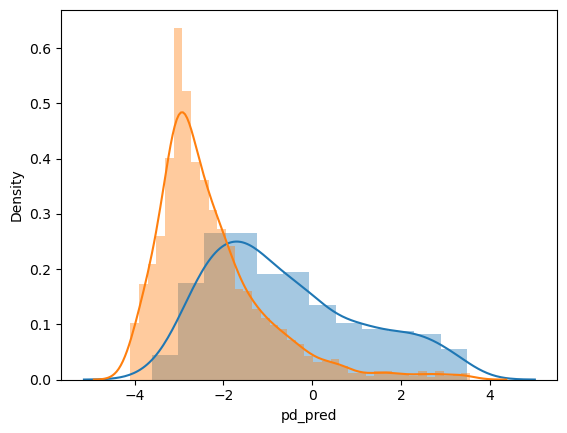

In [41]:
import seaborn as sns
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


/tmp/ipykernel_1433/276717808.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_1433/276717808.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

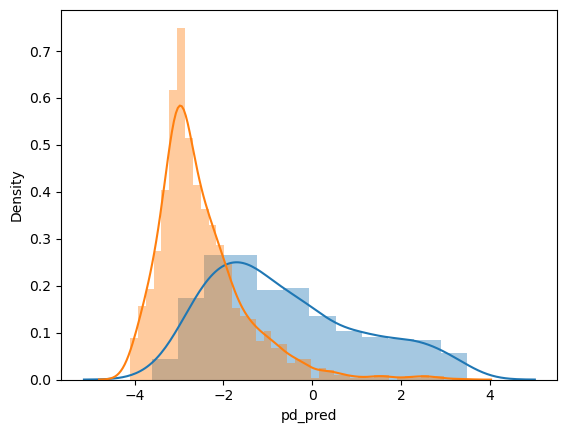

In [42]:
valid_output= valid_output[valid_output.overall_response != 'BL']
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


In [61]:
from sklearn.metrics import roc_auc_score
import matplotlib as plt
from utils_102023 import eval_model
%matplotlib inline

In [62]:
# AUROC for getting pdscans
roc_auc_score(valid_output.outcome, valid_output.pd_pred)


0.8487539259562429

AUC 0.8487539259562429
Outcome probability: 0.21204579392732703
Average precision score: 0.62
Best F1: 0.598952879581152


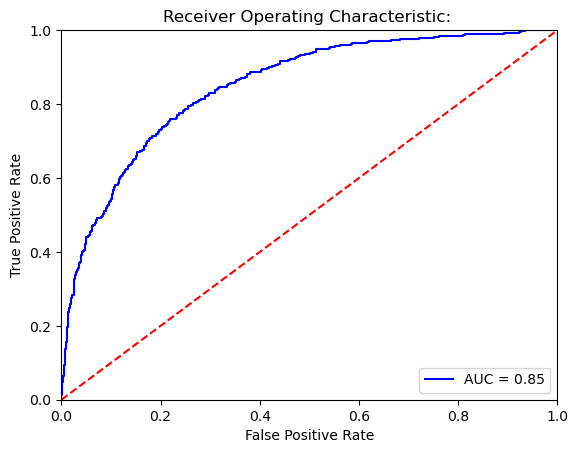

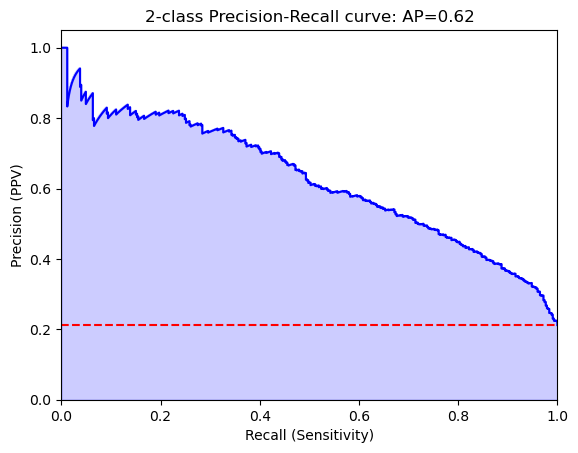

Threshold for best F1:
-1.6393487
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1340  243]
 [ 140  286]]


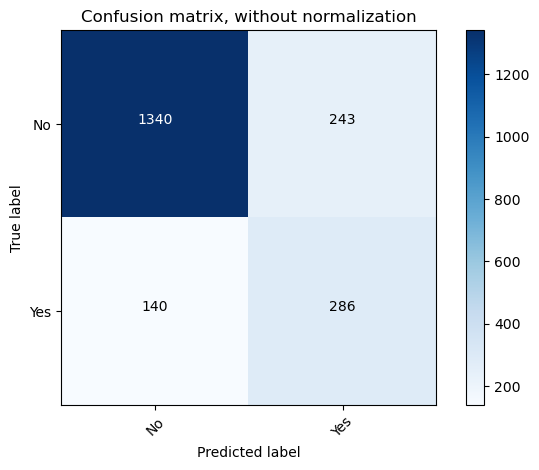

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.91      0.85      0.87      1583
         Yes       0.54      0.67      0.60       426

    accuracy                           0.81      2009
   macro avg       0.72      0.76      0.74      2009
weighted avg       0.83      0.81      0.82      2009

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1556   27]
 [ 320  106]]


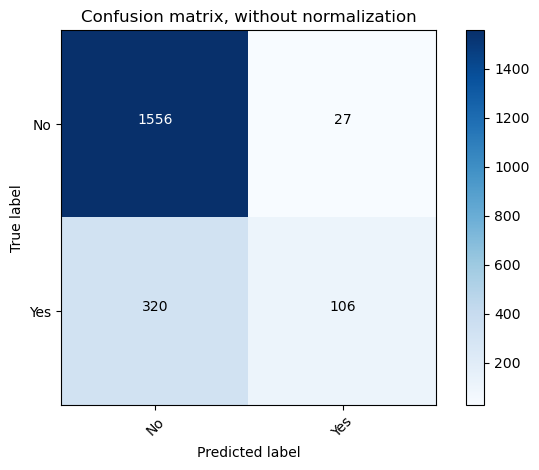

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.83      0.98      0.90      1583
         Yes       0.80      0.25      0.38       426

    accuracy                           0.83      2009
   macro avg       0.81      0.62      0.64      2009
weighted avg       0.82      0.83      0.79      2009



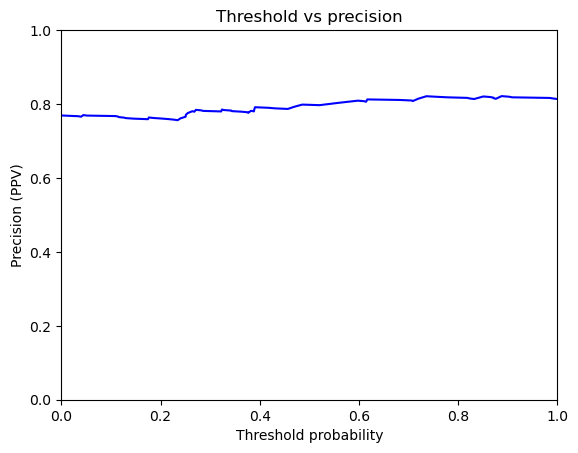

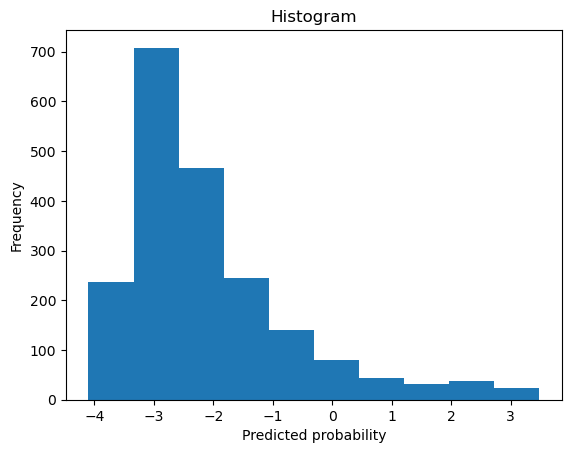

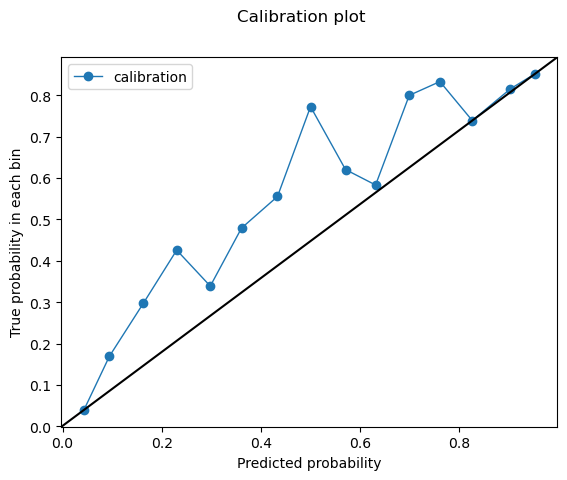

-1.6393487

In [63]:
eval_model(valid_output.pd_pred, valid_output.outcome, graph=True)

In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096 entries, 148 to 60471
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               6096 non-null   int64         
 1   dfci_mrn                 6096 non-null   int64         
 2   date                     6096 non-null   datetime64[ns]
 3   report_text              6096 non-null   object        
 4   protocol                 6096 non-null   object        
 5   overall_response         6096 non-null   object        
 6   narrative_text           6096 non-null   object        
 7   impression_text          3350 non-null   object        
 8   drop_this_obs            6096 non-null   bool          
 9   split                    6096 non-null   object        
 10  obs                      6096 non-null   int64         
 11  overall_response_factor  6096 non-null   int64         
 12  report_length            6096 n

In [65]:
test.head()
test_day_text = test.copy()
test_day_text['text'] = test_day_text.text.astype(str)
test_day_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096 entries, 148 to 60471
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               6096 non-null   int64         
 1   dfci_mrn                 6096 non-null   int64         
 2   date                     6096 non-null   datetime64[ns]
 3   report_text              6096 non-null   object        
 4   protocol                 6096 non-null   object        
 5   overall_response         6096 non-null   object        
 6   narrative_text           6096 non-null   object        
 7   impression_text          3350 non-null   object        
 8   drop_this_obs            6096 non-null   bool          
 9   split                    6096 non-null   object        
 10  obs                      6096 non-null   int64         
 11  overall_response_factor  6096 non-null   int64         
 12  report_length            6096 n

In [66]:
test_day_text = test_day_text.sort_values(by=['obs','dfci_mrn','time'])

test_day_text['text'] = test_day_text.groupby(['obs','dfci_mrn','time'])['text'].transform(lambda x: ' '.join(x))
test_day_text = test_day_text.groupby(['obs','dfci_mrn','time']).first().reset_index()
test_day_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   obs                      2694 non-null   int64         
 1   dfci_mrn                 2694 non-null   int64         
 2   time                     2694 non-null   int64         
 3   Unnamed: 0               2694 non-null   int64         
 4   date                     2694 non-null   datetime64[ns]
 5   report_text              2694 non-null   object        
 6   protocol                 2694 non-null   object        
 7   overall_response         2694 non-null   object        
 8   narrative_text           2694 non-null   object        
 9   impression_text          1865 non-null   object        
 10  drop_this_obs            2694 non-null   bool          
 11  split                    2694 non-null   object        
 12  overall_response_factor  2694 non-

In [67]:
test_day_text.pd_true.value_counts()

0    2244
1     450
Name: pd_true, dtype: int64

In [68]:
test_day_text.outcome.value_counts()

 0    1720
-1     524
 1     450
Name: outcome, dtype: int64

In [69]:
all_reports.outcome.value_counts()

 0    38775
-1    12631
 1     9188
Name: outcome, dtype: int64

In [70]:
# write out actual validation dataset
themodel = RecistModel()
themodel.load_state_dict(torch.load(prefix+'recist_synthetic_htransformer_pd.pt'))
themodel.to(device)

no_shuffle_test_dataset = data.DataLoader(LabeledRecistDataset(test.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)



dflist = []
for ids, mask, s_times, y_true in no_shuffle_test_dataset:
    thisframe = pd.DataFrame()
    
    with torch.no_grad():
        y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
    thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = test_day_text.reset_index(drop=True)



test_output = pd.concat([output, resultframe], axis=1)
test_output = test_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)






/home/klkehl/miniconda3/envs/pytorch2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [71]:
test_output = test_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)




In [72]:
import seaborn as sns
import pandas as pd
import numpy as np


/tmp/ipykernel_1433/3481388163.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_1433/3481388163.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

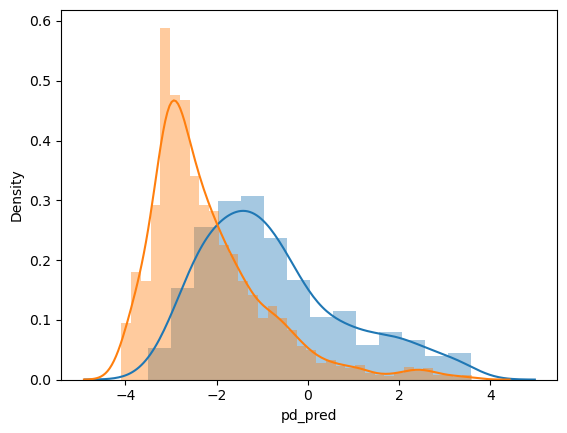

In [73]:
import seaborn as sns
sns.distplot(test_output.query('pd_true==1').pd_pred)
sns.distplot(test_output.query('pd_true==0').pd_pred)


/tmp/ipykernel_1433/708031868.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_1433/708031868.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

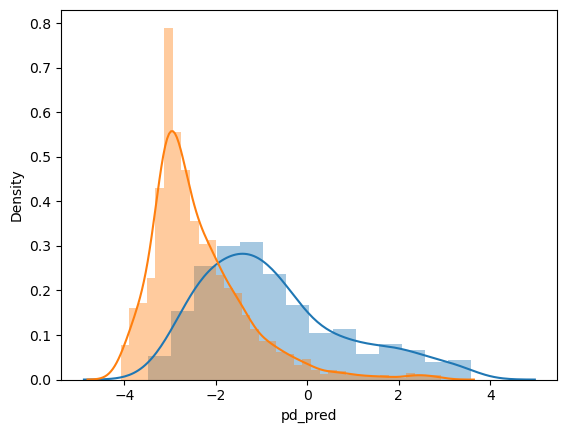

In [74]:
test_output= test_output[test_output.overall_response != 'BL']
sns.distplot(test_output.query('pd_true==1').pd_pred)
sns.distplot(test_output.query('pd_true==0').pd_pred)


In [75]:
from sklearn.metrics import roc_auc_score
import matplotlib as plt

%matplotlib inline

In [76]:
# AUROC for getting pdscans
roc_auc_score(test_output.outcome, test_output.pd_pred)


0.8284793281653746

AUC 0.8284793281653746
Outcome probability: 0.2073732718894009
Average precision score: 0.55
Best F1: 0.5637931034482758


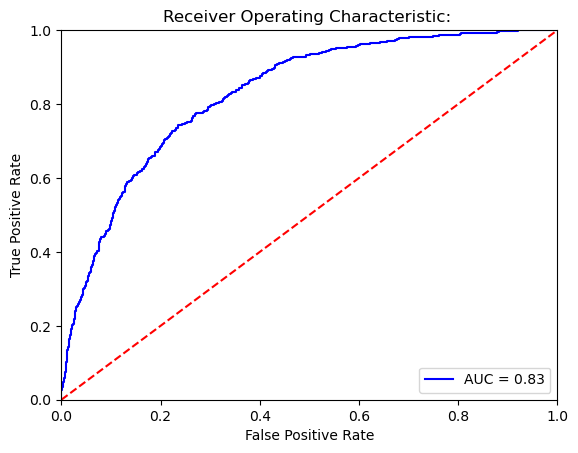

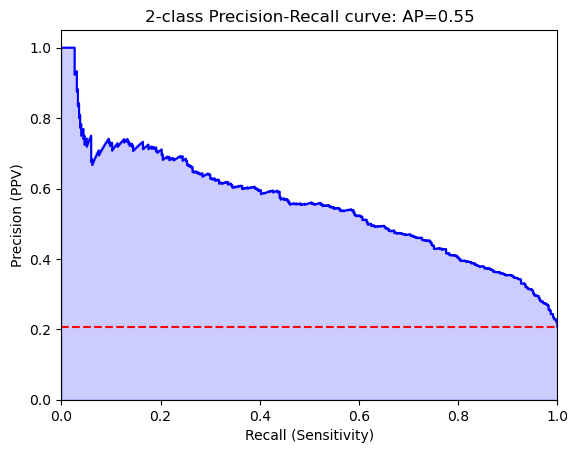

Threshold for best F1:
-1.798367
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1337  383]
 [ 123  327]]


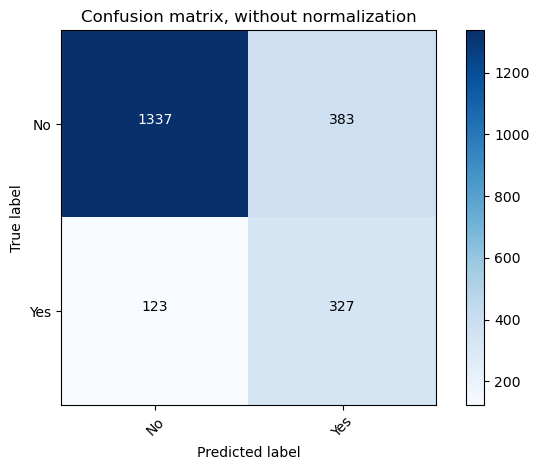

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.78      0.84      1720
         Yes       0.46      0.73      0.56       450

    accuracy                           0.77      2170
   macro avg       0.69      0.75      0.70      2170
weighted avg       0.82      0.77      0.78      2170

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1679   41]
 [ 358   92]]


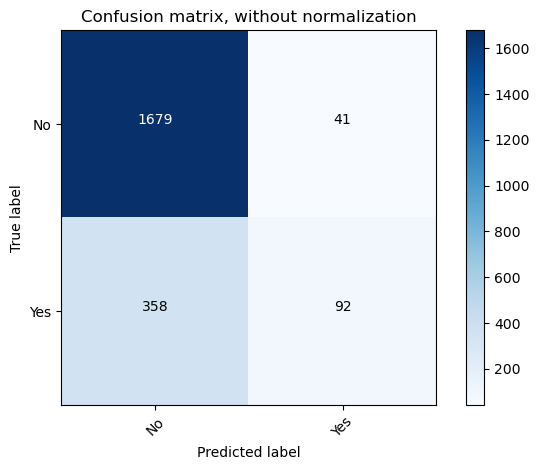

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      0.98      0.89      1720
         Yes       0.69      0.20      0.32       450

    accuracy                           0.82      2170
   macro avg       0.76      0.59      0.60      2170
weighted avg       0.80      0.82      0.77      2170



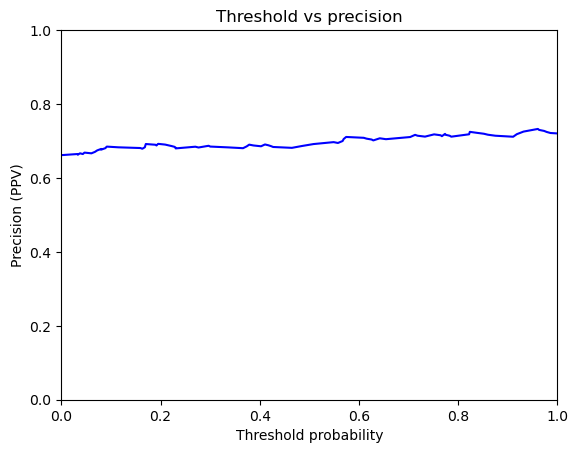

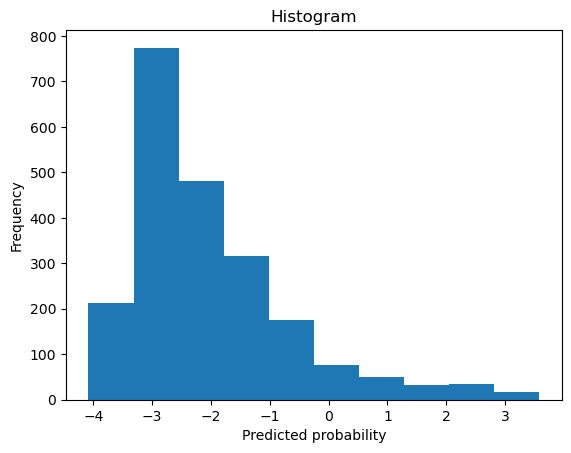

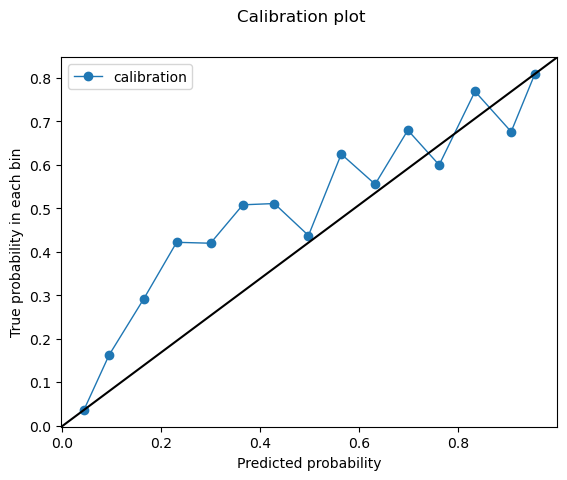

-1.798367

In [77]:
eval_model(test_output.pd_pred, test_output.outcome, graph=True)